In [1]:
import pickle as pkl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import re

In [2]:
from pprint import pprint

### Import

In [3]:
def load_data(dir_path):
    """Load data from pickle files
    
    Keyword arguments:
    file_path -- path to pickle files
    Return: dicts for each file
    """
    with open(dir_path + "output_data_features_class", "rb") as f:
        features_class = pkl.load(f)
    with open(dir_path + "output_data_features_num", "rb") as f:
        features_num = pkl.load(f)
    with open(dir_path + "output_data_votes_class", "rb") as f:
        votes_class = pkl.load(f)
    with open(dir_path + "output_data_votes_num", "rb") as f:
        votes_num = pkl.load(f)
        
    return features_class, features_num, votes_class, votes_num 
    
    

In [4]:
fc, fn, vc, vn = load_data("../data/")
with open("../data/kev.json", "r") as f:
    kev = json.load(f)['vulnerabilities']
kev_set = {i["cveID"] for i in kev}

### Exploratory Data Analysis

In [5]:
df_fn = pd.DataFrame(fn)
df_vn = pd.DataFrame(vn)
df_fn = df_fn.drop(columns=["cve"])
df_vn["vote_num"] = pd.to_numeric(df_vn["vote_num"])

In [6]:
def get_cvelist(text):
    pattern = r"^\*\*CVEs\*\*: (.*)$"
    match = re.search(pattern, text, re.MULTILINE)
    if match:
        cve_list = match.group(1).split(', ')
        if cve_list == ['']:
            return None
        else:   
            return list(set(cve_list))
    else:
        return None

In [7]:
df_fn["cves"] = df_fn["description"].apply(lambda x: get_cvelist(x))
df_fn["in_kev"] = df_fn["cves"].apply(lambda cve_list: any(cve in kev_set for cve in cve_list) if cve_list else False)


In [8]:
def get_vote_means(df: pd.DataFrame, vote_column: str = "vote_num") -> np.ndarray:
    """Get the average vote for each vulnerability"""
    vulns = df["id"].unique()
    
    mean_votes = np.zeros(len(vulns))
    for vuln in vulns:
        mean_votes[vuln - 1] = df[df["id"] == vuln]["vote_num"].apply(lambda x: int(x)).mean()
    
    return mean_votes
  
def get_intern_votes(df: pd.DataFrame, vote_column: str = "vote_num") -> np.ndarray:
    """Get all intern votes for each vulnerability"""
    vulns = df["id"].unique()
    interns = df["user_id"].unique()
    
    intern_votes = np.zeros((max(interns), len(vulns)))
    
    for vote in df.iterrows():
        intern_votes[vote[1]["user_id"] - 1][vote[1]["id"] - 1] = int(vote[1]["vote_num"])
    
    return intern_votes

In [9]:
has_cve = np.array(df_fn[df_fn["cves"].notnull() & ~ df_fn["in_kev"]]["id"]) - 1
in_kev = np.array(df_fn[df_fn["in_kev"]]["id"]) - 1
no_cve = np.array(df_fn[df_fn["cves"].isnull()]["id"]) - 1

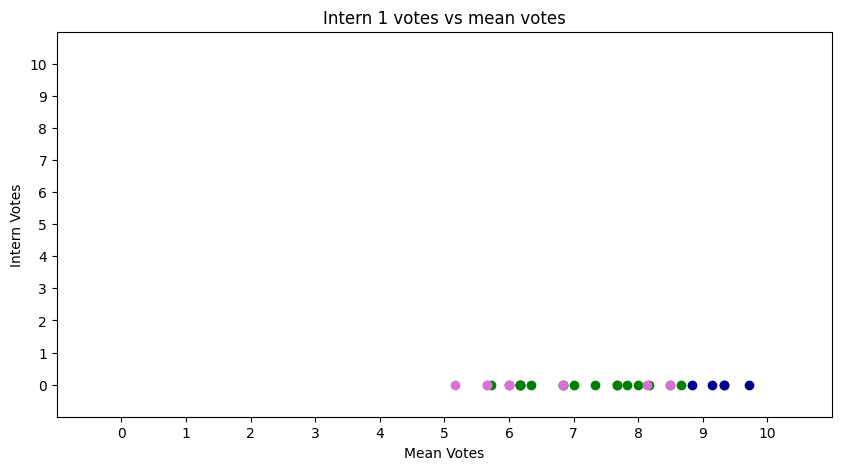

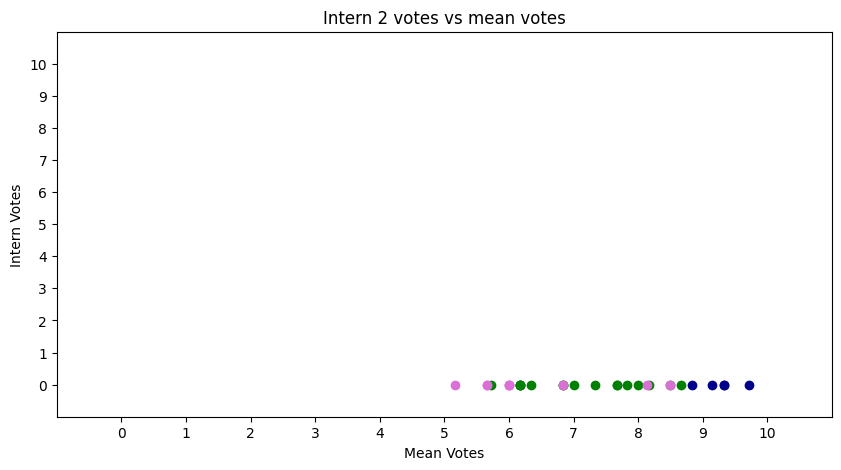

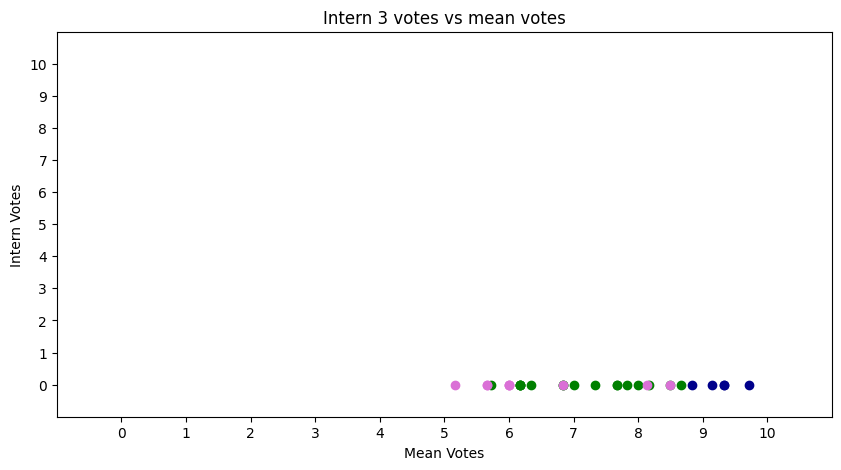

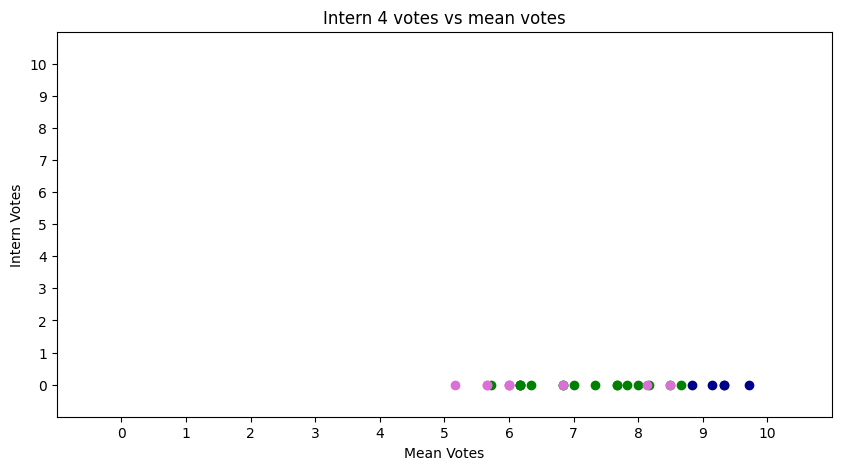

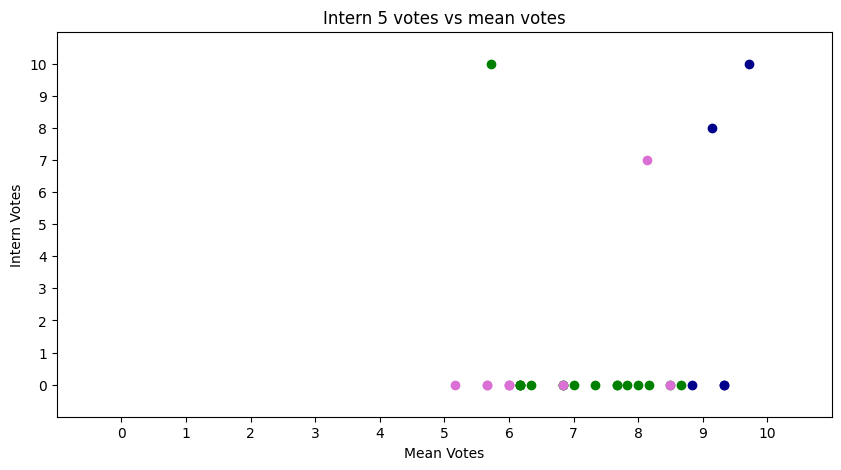

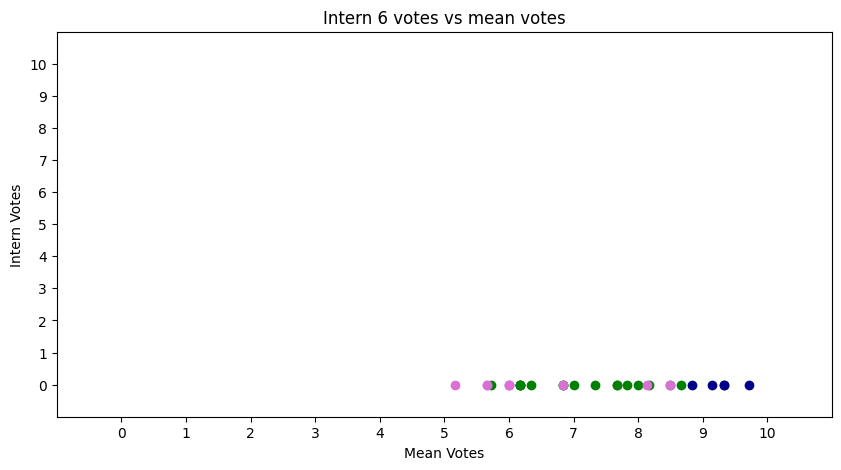

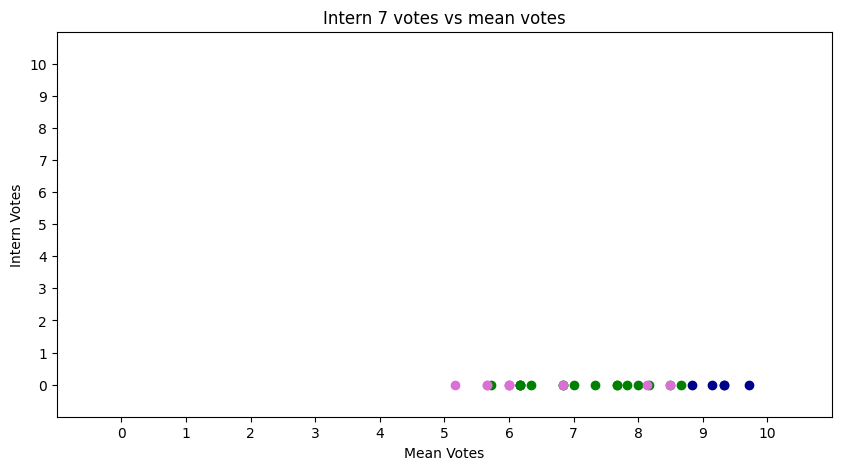

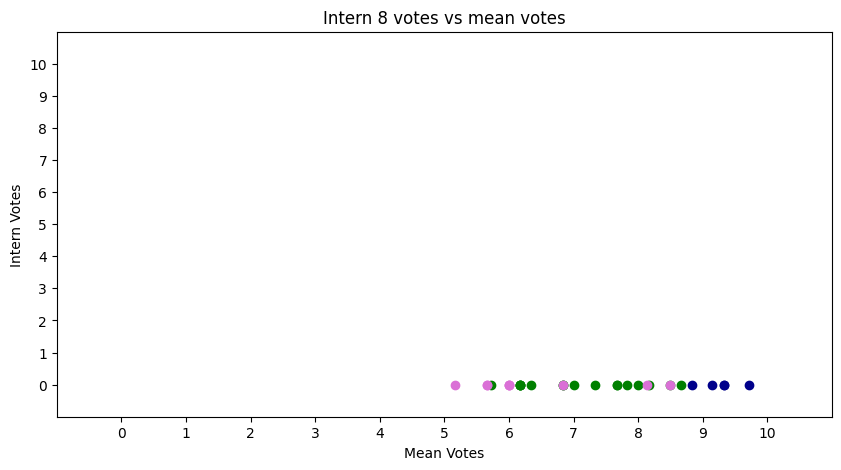

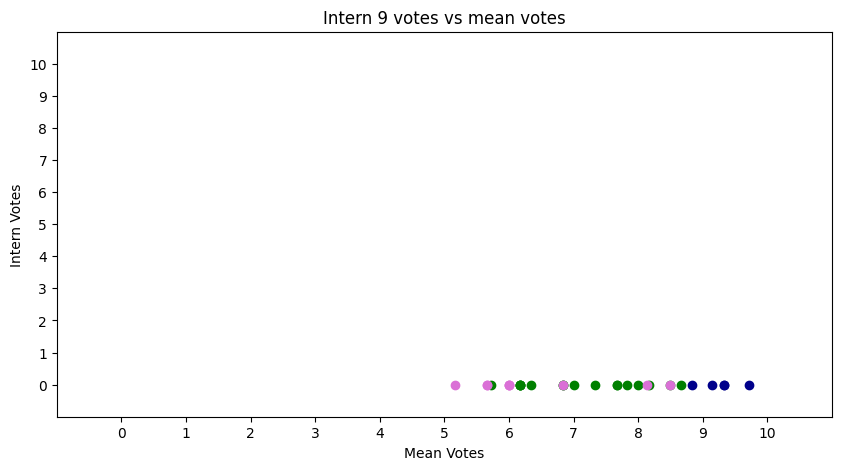

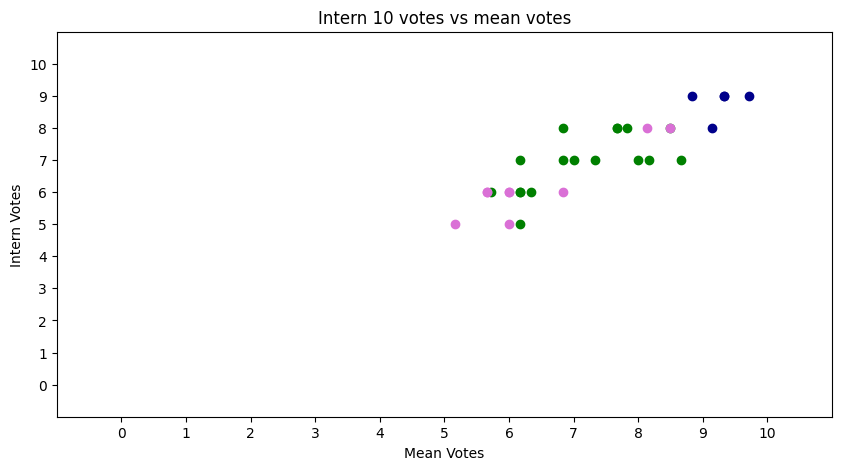

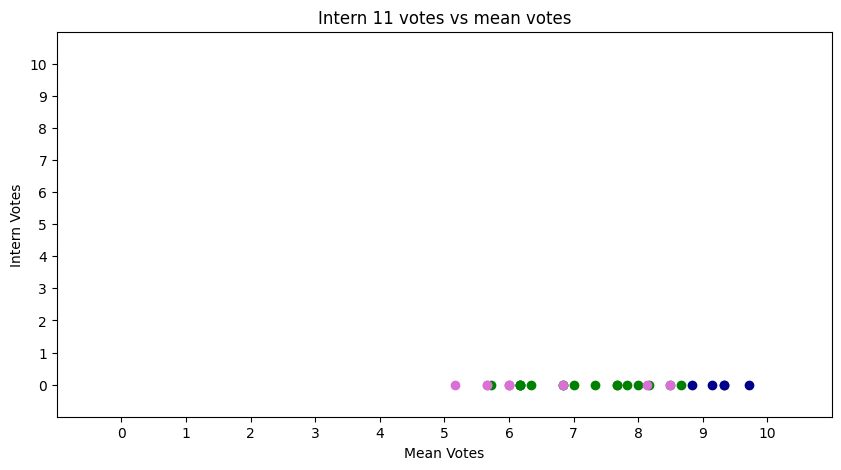

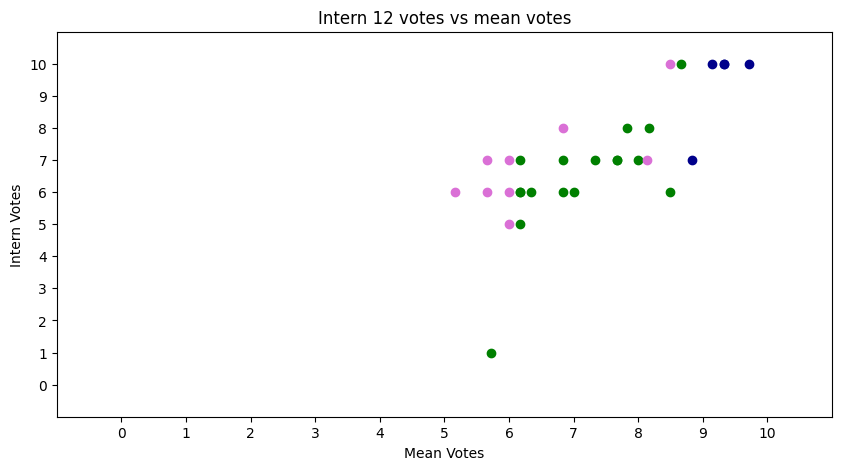

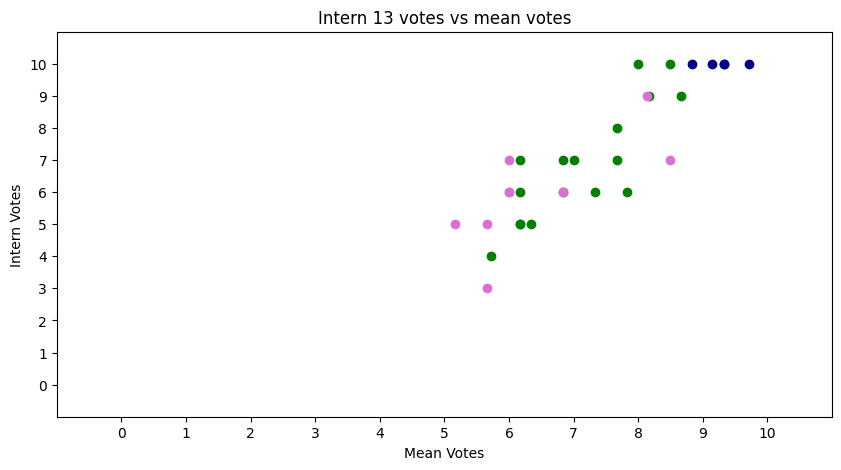

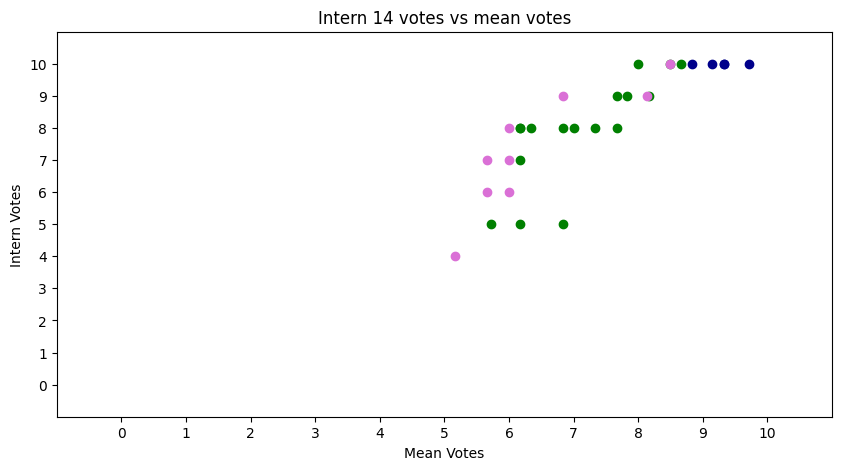

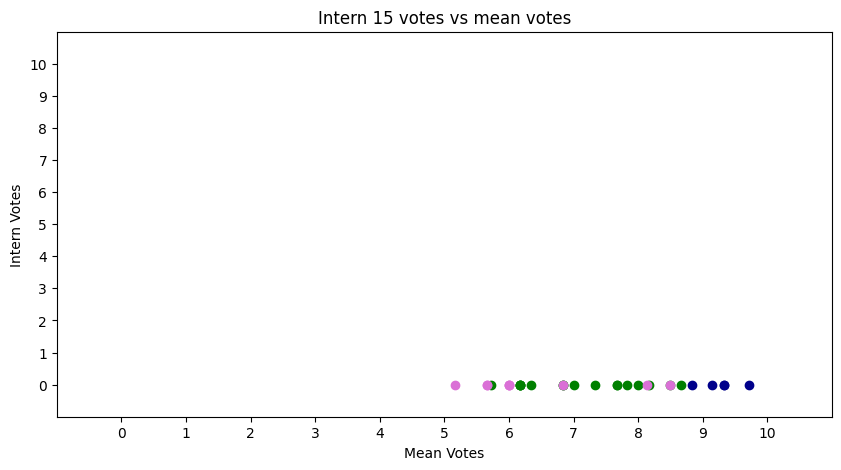

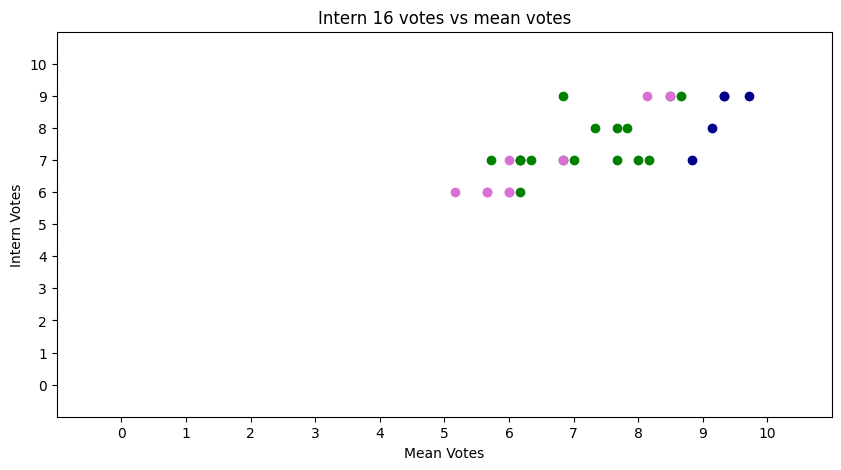

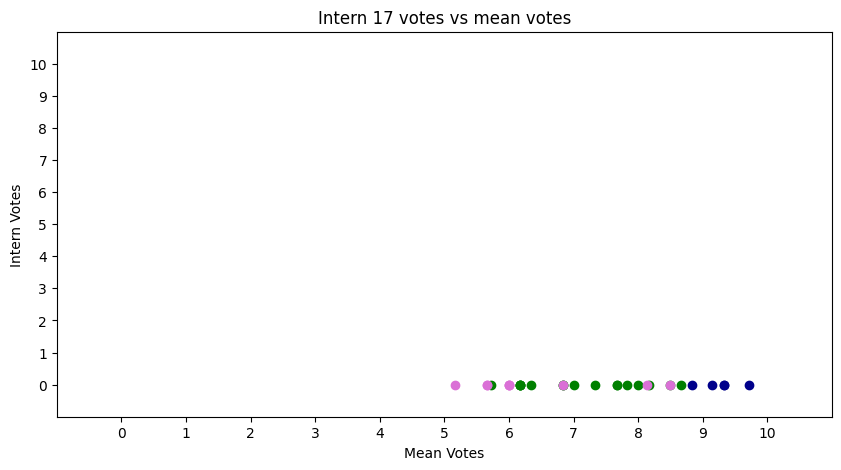

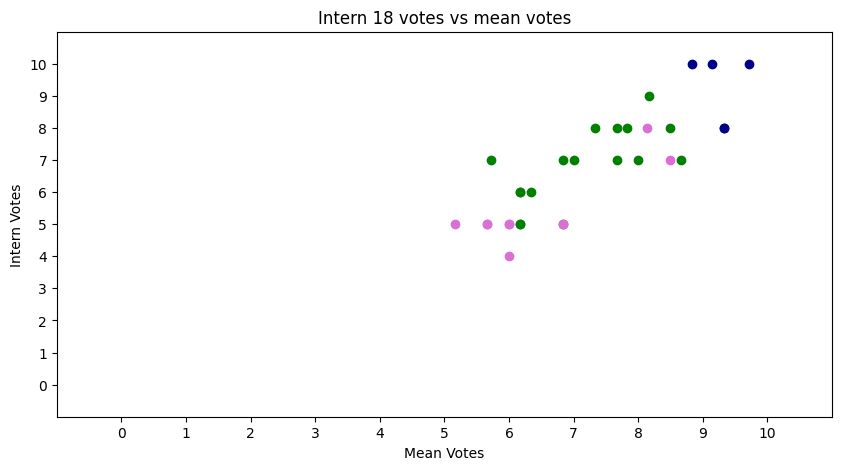

In [ ]:
## get the average votes for each 
mean_votes = get_vote_means(df_vn, vote_column="vote_num")
intern_votes = get_intern_votes(df_vn, vote_column="vote_num")
# print("Mean votes for each vulnerability:")
# print(mean_votes) #mean_votes

# print("Intern votes for each vulnerability:")
# print(intern_votes)


for i in range(len(intern_votes)):
  plt.figure(figsize=(10, 5))
  plt.scatter(mean_votes[in_kev], intern_votes[i][in_kev], color="darkblue", label="Vulnerabilites in KEV")
  plt.scatter(mean_votes[has_cve], intern_votes[i][has_cve], color="green", label="Vulnerabilites with CVEs")
  plt.scatter(mean_votes[no_cve], intern_votes[i][no_cve], color="orchid", label="Vulnerabilites without CVEs")
  plt.title(f"Intern {i+1} votes vs mean votes")
  plt.xlim(-1,11)
  plt.ylim(-1,11)
  plt.yticks(np.arange(0, 11, 1))
  plt.xticks(np.arange(0, 11, 1))
  plt.ylabel("Intern Votes")
  plt.xlabel("Mean Votes")
  plt.plot()